## Data Pre-Processing - Metop B Data

### Workflow Outline




**Repackaging step:**
Strip out sst, lat, long, wind etc.
Re-package based on per-pixel designation
Augment the point locaiton with the solar/lunar information as well using {astral}

Georgy Request
total accounting on 100x100 grid of the total number of satellite observations


In [1]:
# Libraries
import xarray as xr
import os
import L3List as L3
import pandas as pd
import datetime
import astral
import h5netcdf

# Access AWS Credentials from netcr file
s3sys = L3.init_S3FileSystem()

## Access L2 Granules with S3List

Thanks to Nikki & Shanice we are able to locate s3 granules using a lookup class. Using that code, we can discover granules for PODAAC resources using their short_name documentation, a temporal range, and a bbox for further limiting spatial coverage.



In [2]:
# Required data 
short_name = 'AVHRRMTB_G-NAVO-L2P-v2.0'
provider   = 'POCLOUD'
start_date = '2022-07-01T00:00:00Z'
end_date   = '2022-10-31T23:59:59Z'
temporal_range = f'{start_date},{end_date}'
bbox = "-40,0,-35,5" #WSEN

metopb_s3 = L3.S3List()
granule_urls = metopb_s3.login_and_run_query(short_name, provider, temporal_range, bbox)
granule_urls[0:5]

['s3://podaac-ops-cumulus-protected/AVHRRMTB_G-NAVO-L2P-v2.0/20220630231022-NAVO-L2P_GHRSST-SST1m-AVHRRMTB_G-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRMTB_G-NAVO-L2P-v2.0/20220701000721-NAVO-L2P_GHRSST-SST1m-AVHRRMTB_G-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRMTB_G-NAVO-L2P-v2.0/20220701005236-NAVO-L2P_GHRSST-SST1m-AVHRRMTB_G-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRMTB_G-NAVO-L2P-v2.0/20220701014936-NAVO-L2P_GHRSST-SST1m-AVHRRMTB_G-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRMTB_G-NAVO-L2P-v2.0/20220701023536-NAVO-L2P_GHRSST-SST1m-AVHRRMTB_G-v02.0-fv02.0.nc']

In [3]:
# Open a tester
test_xr = xr.open_dataset(s3sys.open(granule_urls[0]))
test_xr

<xarray.Dataset>
Dimensions:                      (nj: 6914, ni: 409, time: 1)
Coordinates:
    lat                          (nj, ni) float32 ...
    lon                          (nj, ni) float32 ...
  * time                         (time) datetime64[ns] 2022-06-30T23:10:22
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    ...                           ...
    satellite_zenith_angle       (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    quality_level                (time, nj, ni) float32 ...
    brightness_temperature_4um   (time, nj, ni) float32 ...
    brightness_temperature_11um  (time, nj, ni) float32 ...
    brightness_temperature_12um  (time, nj, ni) float32 ...
Attributes: (12/46)
    Conventions:                CF-1.6
    title:                      MetOpB L2P SST
    summary:                    Sea Surface temperature retrievals produced a...
    references:                 NAVOCEANO MCSST
    institution:                NAVO
    history:                    Created with fsst on  2022/07/01 at 00:30:46 UT
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath

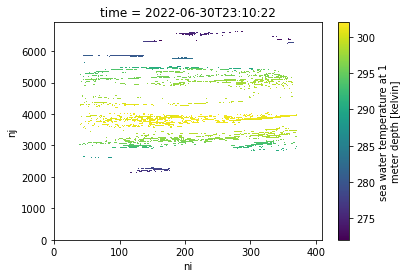

In [4]:
# Plot
test_xr.sea_surface_temperature.isel(time = 0).plot()

## Conversion from Satellite Point-obs to Tabular Data

Because the satellite swaths do not overlap perfectly, they do not open together succesfully as one xarray array. To preserve the original satellite measurement locations these measurements can be converted into a tabular format and rowbinded to create a complete record.

At this point, while they are still xr.Datasets, it would be possible to easily apply a lat/lon limit to the datasets to suite project needs.

Additional steps strip away unnecessary variables for the SST analysis. Re-Packing includes 
 * sea_surface_temperature
 * quality Level (3-5)
 * l2p_flags
 * SSES_bias, 
 * SSES_standard_deviation, 
 * wind_speed
 * and others...
  
  
Coordinates: lat/lon/sst_dtime


In [ ]:

# Set longitude and latitude limits of study area using xarray
lon_min = -40
lat_min = 0
lon_max = -35
lat_max = 5

# Set Minimum Quality level
min_qual = 3


# Put each file into a list as a df
granule_list = []
for url in granule_urls[0:10]:
    
    # Open Granule
    array_s3 = s3sys.open(url) 
    
    #Load with xr
    array_i = xr.open_dataset(array_s3) 
    
    # Drop Variables We don't need
    array_i = array_i.drop(
        ["brightness_temperature_4um", "brightness_temperature_11um", "brightness_temperature_12um",
         "sses_bias", "sses_standard_deviation", "aerosol_dynamic_indicator", "adi_dtime_from_sst"])
    
    # Make it a dataframe
    df = array_i.to_dataframe()
    # Drop NA SST
    df = df.dropna(subset=['sea_surface_temperature'])
    # Drop Indexes ni, nj
    df = df.reset_index(["nj", "ni"], drop=True)
    
#     # # Subset lat/lon/data_quality to suit bounds
#     indexlon  = (df.lon >= lon_min) & (df.lon <= lon_max)
#     indexlat  = (df.lat >= lat_min) & (df.lat <= lat_max)
#     indexqual = df.quality_level >= min_qual
    
#     # Subset using ^
#     df = df[indexlon & indexlat & indexqual]
    
    # Add to list of all granules
    granule_list.append(df)

# Check the first one
granule_list[0]


In [ ]:
# From theat list create one mega dataframe
metops_df = pd.concat(granule_list)

# Check the Damage
metops_df.head()

# Augment with Pixel Datetime

In [ ]:
# astral

---

# Deprecated

### Access Downloads - PODAAC Data Downloader

Data was acquired directly from PODAAC using PODAAC Data Downloader, a command line tool. Data was downloaded using the following command in the terminal:

`podaac-data-downloader -c AVHRRMTB_G-NAVO-L2P-v2.0 -d ./l2_data/metop -sd 2018-01-13T00:00:00Z -ed 2018-01-14T00:00:00Z`

The files downloaded from PODAAC have been saved in a project sub-directory. These file names can be accessed using the {os} library to build a list of path names that could possibly be opened using `xarray.open_mfdataset()`.

In [6]:
# Path to Resource
l2_resource = "metop"
l2_path = f'../l2_data/{l2_resource}'

# Collect/Open all .nc files
metops_l = os.listdir(f"{l2_path}")
resource_files = []
for file in metops_l:
    resource_files.append(f"{l2_path}/{file}")
#resource_files[0]

# Open Single File with xarray
metop = xr.open_mfdataset(resource_files[0])
metop

<xarray.Dataset>
Dimensions:                      (nj: 6212, ni: 409, time: 1)
Coordinates:
    lat                          (nj, ni) float32 dask.array<chunksize=(6212, 409), meta=np.ndarray>
    lon                          (nj, ni) float32 dask.array<chunksize=(6212, 409), meta=np.ndarray>
  * time                         (time) datetime64[ns] 2022-10-01T16:56:52
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sea_surface_temperature      (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sst_dtime                    (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sses_bias                    (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sses_standard_deviation      (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    dt_analysis                  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    wind_speed                   (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    ...                           ...
    satellite_zenith_angle       (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    l2p_flags                    (time, nj, ni) int16 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    quality_level                (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_4um   (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_11um  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_12um  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                CF-1.6
    title:                      MetOpB L2P SST
    summary:                    Sea Surface temperature retrievals produced a...
    references:                 NAVOCEANO MCSST
    institution:                NAVO
    history:                    Created with fsst on  2022/10/01 at 18:15:42 UT
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath

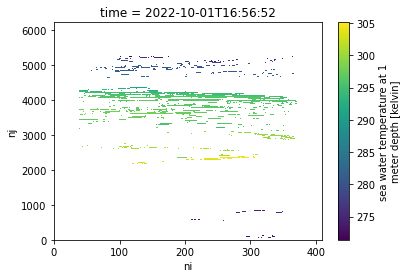

In [7]:
# Plot one
metop.sea_surface_temperature.isel(time = 0).plot()